# Wavelet denoising

Powerful signal processing technique that uses the wavelet transform to remove noise from signals. The fundamental idea is to transform the noisy signal into the wavelet domain, where it can be more effectively denoised by thresholding the wavelet coefficients, and then reconstructing the signal from the thresholded coefficients.

## Wavelet Denoising Steps
1. **Wavelet Decomposition:** Decompose the noisy signal into wavelet coefficients.
2. **Thresholding:** Apply a thresholding technique to the wavelet coefficients to remove noise.
3. **Inverse Wavelet Transform:** Reconstruct the denoised signal from the thresholded wavelet coefficients.

## Implementations

![waveletDenoiseImplementations](wavelet_denoise.png "Denoising Architectures")

### Denoise

Only removes the noise estimated from the higher frequency coefficients. It is the gold standart and the most implemented for ECG and PCG denoising. These implementations consider that the signals are already centered in 0

### Denoise 2

Takes the traditional denoising architecture, but forces the low frequency coefficients (approximation coefficients) to be 0, forcefully removing this information. For this approach to be effective, the decomposition levels must be carefully selected to eliminate the lower band frequencies. I haven't see this implemented or explained in any paper

### Denoise 3

Includes the approximation coefficients into the thresholding, denoising this band as well. **My concerns with this approach is the necessity of two noise level coefficients, for high and low frequencies. I propose keeping the high frequency noise coefficients, and for the approximation coefficients substract the mean or the median**

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import pywt
import pydub
import time
import sounddevice as sd
from scipy import signal
from biosppy.signals import ecg

## Functions

In [2]:
def softThreshold (signal, lbda):
    return np.sign(signal) * np.maximum(np.abs(signal) - lbda, 0)

def residuals (filtered, raw):
    return  raw - filtered[:len(raw)]

def rootMeanSquare(x):
    return np.sqrt(np.mean(x**2))

def meanSquareError(filtered, raw):
    filtered = np.array(filtered)
    raw = np.array(raw)
    return np.mean((raw - filtered[:len(raw)]) ** 2)

def signalPower(signal):
    return np.mean(signal **2)

def snrPower(signal, noise):
    signal_power = signalPower(signal)
    noise_power = signalPower(noise)
    return 20 * np.log10(signal_power / noise_power)

def snrAmplitude(signal, noise):
    return 10 * np.log10((np.max(signal)-np.min(signal))/(np.max(noise)-np.min(noise)))

#The Classic SNR definition is modified for avoiding artificially improved RMS due to the unremoved DC component
# for doing such, the signals will be detrended by removing the median


def snrMSE(filtered, raw):
    mse = meanSquareError(filtered, raw)
    filtered_detrend = filtered - np.median(filtered)
    signal_power = signalPower(filtered_detrend)
    snr =  10 * np.log10(signal_power / mse)
    return snr

def snrRMS(signal, noise):
    signal = np.array(signal)
    noise = np.array(noise)
    # detrend data
    signal_detrended = signal - np.median(signal)
    noise_detrended = noise - np.median(noise)
    return 10 * np.log10(rootMeanSquare(signal_detrended)/(rootMeanSquare(noise_detrended)))

def snrVPP(signal, noise):
    signal = np.array(signal)
    noise = np.array(noise)
    # detrend data
    signal_detrended = signal - np.median(signal)
    noise_detrended = noise - np.median(noise)
    return 10 * np.log10((np.max(signal_detrended)-np.min(signal_detrended))/(rootMeanSquare(noise_detrended)))

def bandPassButterworth(data, a, b, order, rate, decimate=1):
    coefficients = signal.butter(order, [a, b], btype="bandpass", output="sos", fs=rate)
    filt = signal.sosfiltfilt(coefficients, data)
    return signal.decimate(filt, decimate)

"""
def sureLambda():

def bayesShrinkLambda():

def normalShrinkLambda():

def fdrLambda():
"""

'\ndef sureLambda():\n\ndef bayesShrinkLambda():\n\ndef normalShrinkLambda():\n\ndef fdrLambda():\n'

### Universal Lambda (VisuShrink)

**Ideal for denoising signals corrupted by Gaussian white noise**

$$\lambda = \sigma \sqrt{2*log\left( n \right)}$$

- $\sigma$ estimated noise
- $n$ number of data points in the signal

The estimated noise $\sigma$ obtainned suing the median absolute deviation (MAD) of the wavelet detail coefficients at the finest scale:

$$\sigma = \frac{median\left( \left| d_1 \right| \right)}{0.6745}$$

In [3]:
def universalWVDenoise(signal, family, level):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-2]))/0.674
    n = len(signal)
    lbda = sigma * np.sqrt(2*np.log(n))
    wv_coeffs[1:] = [pywt.threshold(c, lbda, mode='soft') for c in wv_coeffs[1:]]
    return pywt.waverec(wv_coeffs, wavelet=family)

def universalWVDenoise2(signal, family, level):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-2]))/0.674
    n = len(signal)
    lbda = sigma * np.sqrt(2*np.log(n))
    for i in range(len(wv_coeffs)-1):
        wv_coeffs[i+1] = softThreshold (wv_coeffs[i+1], lbda)
    wv_coeffs[0][:] = 0
    return pywt.waverec(wv_coeffs, wavelet=family)

def universalWVDenoise3(signal, family, level):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-2]))/0.674
    n = len(signal)
    lbda = sigma * np.sqrt(2*np.log(n))
    wv_coeffs[:] = [pywt.threshold(c, lbda, mode='soft') for c in wv_coeffs[:]]
    return pywt.waverec(wv_coeffs, wavelet=family)

### miniMax Threshold

**Theory:**

The minimax threshold is derived from the minimax principle in statistical decision theory, which aims to minimize the maximum possible error. It is often used when the signal length is relatively small.

It minimizes the maximum risk in estimation, Balances noise reduction and signal presetvation, but i'ts less adaptive to varying noise

**Governing Formula:**

The minimax threshold $\lambda$ is given by preset values depending on the length of the signal:

- For $n < 32: \lambda = 0$
- For $32 \le n < 1024: \lambda = 0.3936 + 0.1829 \: log_2(n)$
- For $n \ge 1024: \lambda = 0.3936 + 0.2365 \: log_2(n)$


In [4]:
def minimaxWVDenoise(signal, family, level):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    n = len(signal) 
    if n < 32:
        lbda = 0
    elif n < 1024:
        lbda = 0.3936 + 0.1829 * np.log2(n)
    else:
        lbda = 0.3936 + 0.2365 * np.log2(n)
    for i in range(len(wv_coeffs)-1):
        wv_coeffs[i+1] = softThreshold (wv_coeffs[i+1], lbda)
    wv_coeffs[0][:] = 0
    return pywt.waverec(wv_coeffs, wavelet=family)

### SURE Threshold (Stein's Unbiased Risk Estimate)

**Theory:**

SURE (Stein's Unbiased Risk Estimate) thresholding is an adaptive method that estimates the threshold by minimizing an unbiased estimate of the risk (mean squared error). It is data-driven and adapts to the underlying signal and noise characteristics.

Adaptive denoising, adapts to data, minimizes risk estimation, but it's computationally intensive

**Governing Formula:**

The SURE threshold $\lambda_{SURE}$ is found by minimizing the SURE risk estimate:

$$SURE\left( \lambda \right)=n\sigma^2+\sum_{i=1}^{n}min\left( \left| x_i \right|^2, \lambda^2 \right)-2\sigma^2\sum_{i=1}^{n}I\left( \left| x_i \right| \le \lambda \right)$$

where:
- $n$ is the number of data points
- $\sigma$ is the noise standard deviation
- $x_i$ are the wavelet coefficients
- $I(\cdot)$ is the indicator function

In [5]:
def sureWVDenoise(signal, family, level):
    coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(coeffs[-2]))/0.674
    n = len(signal)

    thresholds = np.linspace(0, np.max(np.abs(coeffs[1])), 100)
    
    best_threshold = thresholds[0]
    min_risk = float('inf')

    #denoised_coeffs = coeffs
    
    for t in thresholds:
        denoised_coeffs = [pywt.threshold(c, t, mode='soft') for c in coeffs]
        denoised_data = pywt.waverec(denoised_coeffs, wavelet=family)
        risk = np.sum((signal - denoised_data[:len(signal)]) ** 2) / n
        
        if risk < min_risk:
            min_risk = risk
            best_threshold = t
    
    denoised_coeffs = [pywt.threshold(c, best_threshold, mode='soft') for c in coeffs]
    denoised_coeffs[0][:] = 0
    return pywt.waverec(denoised_coeffs, wavelet=family)

### Import signal

[]

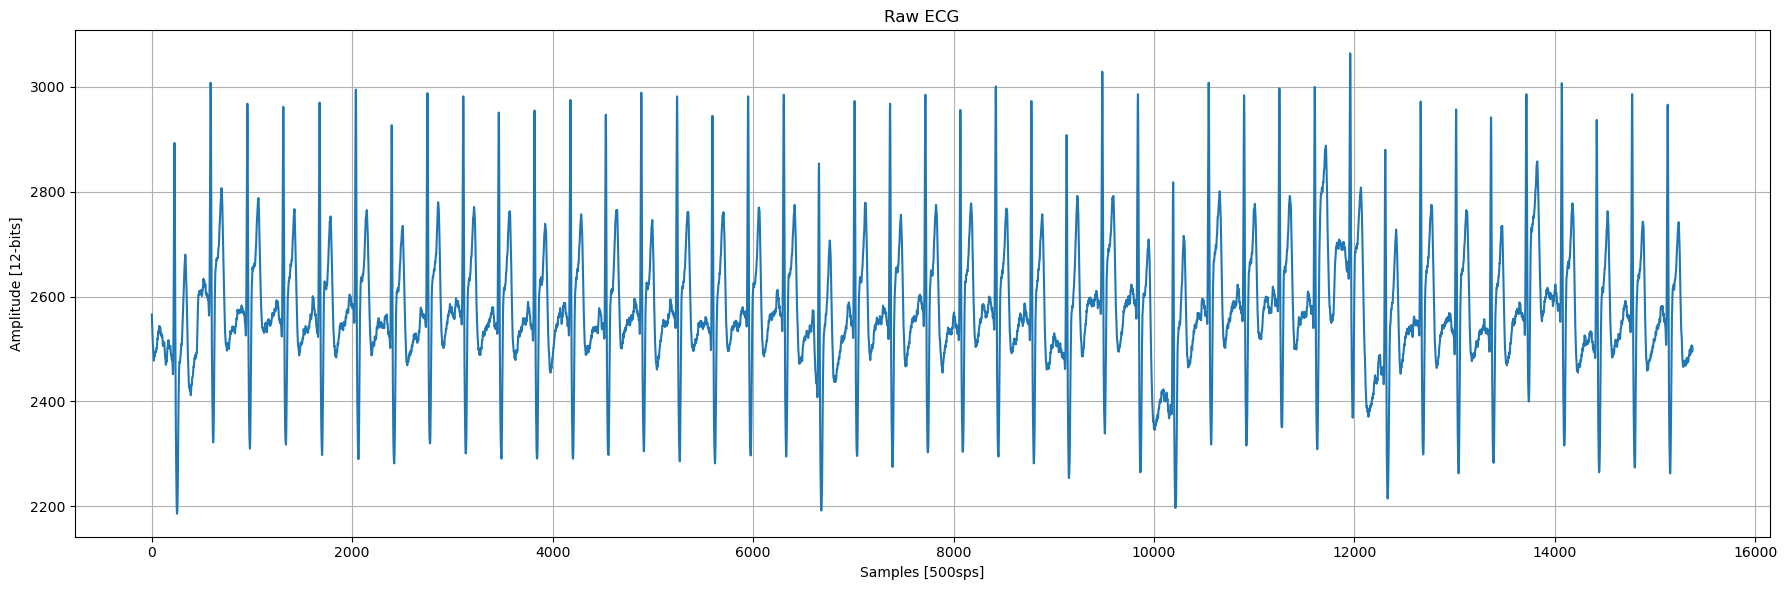

In [6]:
#%% Import signals

# Declare files path
PCG_path = r"C:/Users/danie/Dropbox/PhD/SignalQuality/DatasetCHVNGE/16_TV.mp3"
ECG_path = r"C:/Users/danie/Dropbox/PhD/SignalQuality/DatasetCHVNGE/16_TV.raw"

## Import PCG
a = pydub.AudioSegment.from_mp3(PCG_path)
PCG_rate = a.frame_rate
t = a.duration_seconds
PCG = np.array(a.get_array_of_samples())
PCG_bit_width = 16

## Import ECG
ECG = np.loadtxt(ECG_path, delimiter=",", dtype=int)
ECG_rate = 500
ECG_bit_width = 12
ECG_resolution = (2 ** ECG_bit_width)-1

## Normalize full-scale
#ECG_v = (ECG - ECG_resolution/2) / (ECG_resolution) #int 12 bits (scale -0.5;0.5)

plt.figure(figsize=(18, 6))
plt.plot(ECG)
plt.grid()
plt.xlabel('Samples [500sps]')
plt.ylabel('Amplitude [12-bits]')
plt.title('Raw ECG')
plt.tight_layout()

plt.plot()

# Universal (VisuShrink) Filtering

## Denoise 1

Text(0.02, 0.5, 'Amplitude [12-bits]')

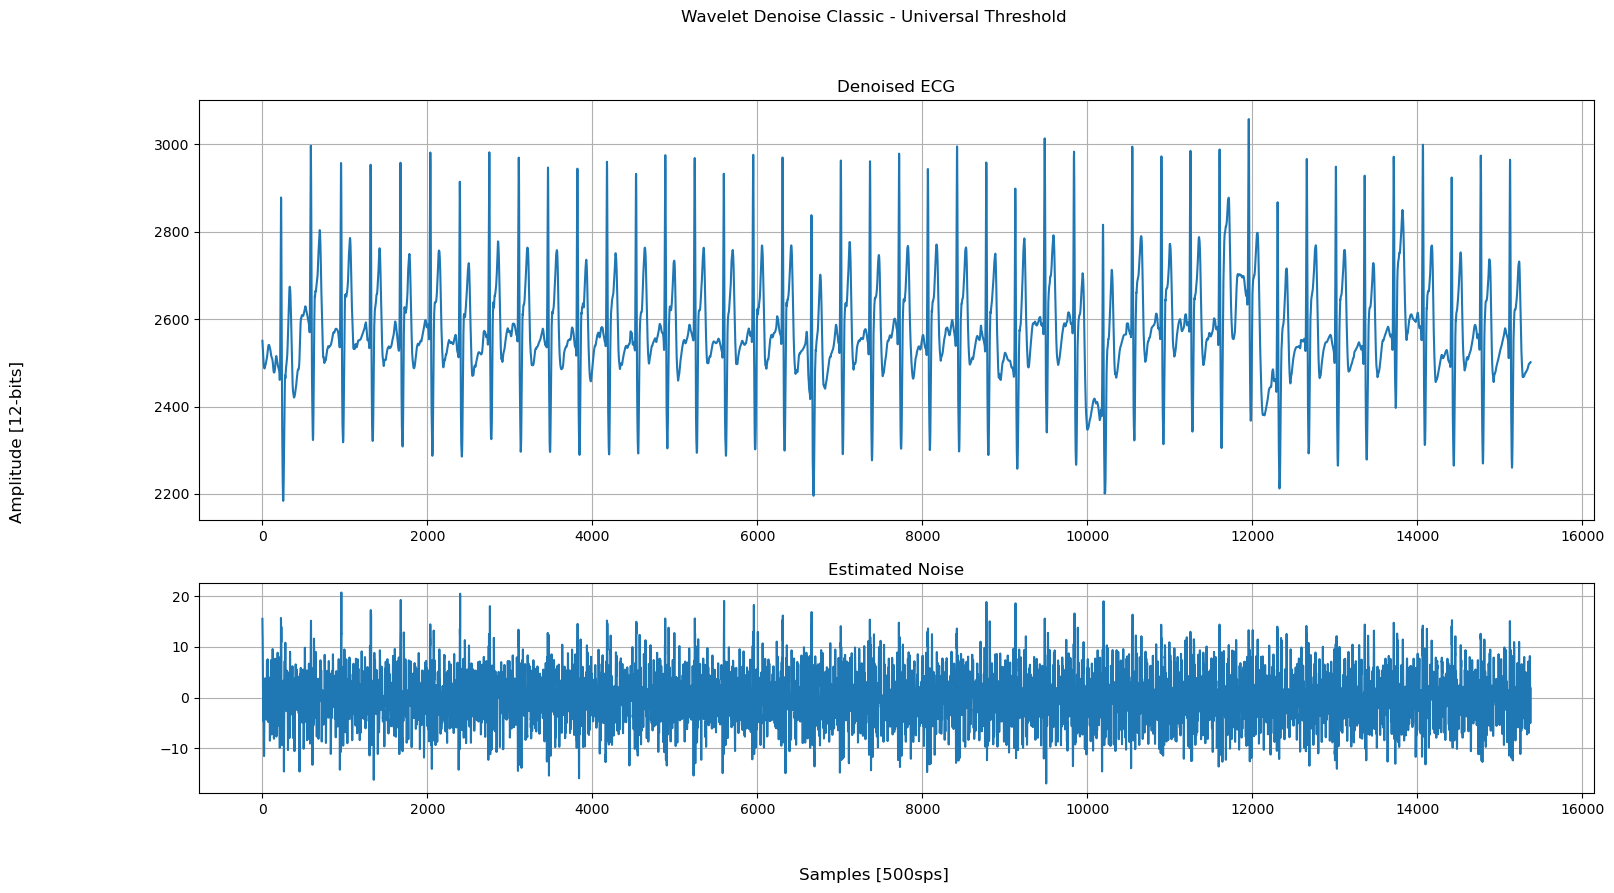

In [7]:
# Signal Denoise
ECG_wv_universal1 = universalWVDenoise(ECG, 'db4', 5)
e_universal_1 = residuals (ECG_wv_universal1, ECG)
# noise level metrics
mse_universal1 =  meanSquareError(ECG_wv_universal1, ECG)
snr_power_universal_1 = snrPower(ECG_wv_universal1, e_universal_1)
snr_amplitude_universal_1 = snrAmplitude(ECG_wv_universal1, e_universal_1)
snr_MSE_universal_1 = snrMSE(ECG_wv_universal1, ECG)
snr_RMS_universal_1 = snrRMS(ECG_wv_universal1, e_universal_1)
snr_VPP_universal_1 = snrVPP(ECG_wv_universal1, e_universal_1)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Classic - Universal Threshold')
axs[0].plot(ECG_wv_universal1)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_1)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

## Denoise 2

Here I go down 10 levels since the ECG is defined between 0.5 - 150 Hz

- lv0: DC - 500Hz
- lv1: DC - 2500Hz
- lv2: DC - 125Hz
- lv3: DC - 62.5Hz
- lv4: DC - 31.25Hz
- lv5: DC - 15.63Hz
- lv6: DC - 7.81Hz
- lv7: DC - 3.9Hz
- lv8: DC - 1.95Hz
- lv9: DC - 0.98Hz
- lv10: DC - 0.49Hz

Text(0.02, 0.5, 'Amplitude [12-bits]')

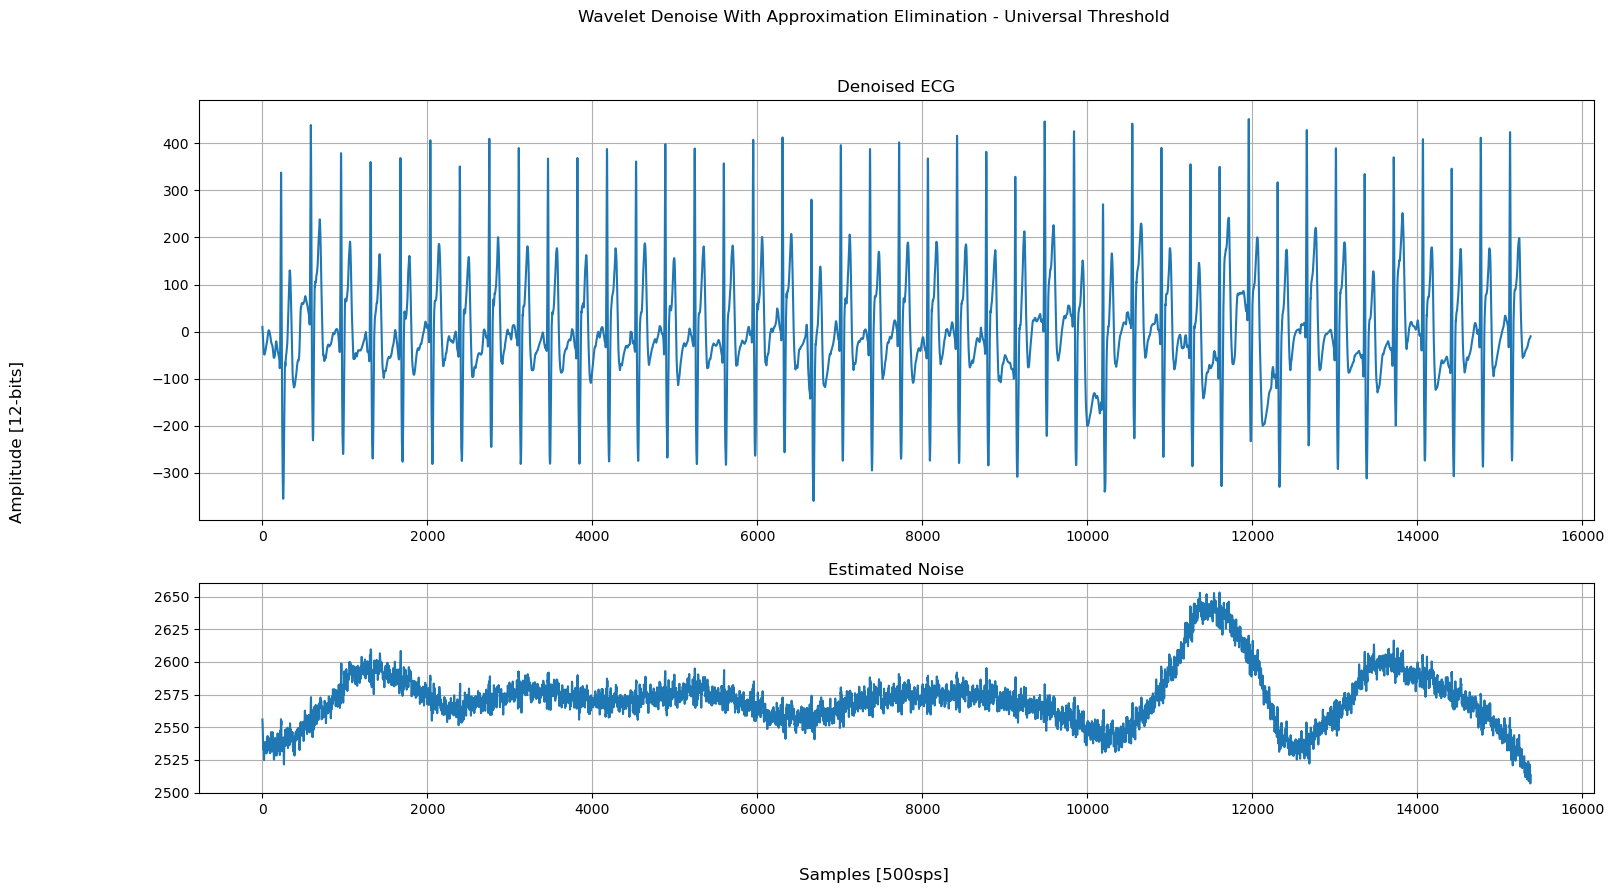

In [8]:
# Signal Denoise
ECG_wv_universal2 = universalWVDenoise2(ECG, 'db4', 10)
e_universal_2 = residuals (ECG_wv_universal2, ECG)
# noise level metrics
mse_universal2 =  meanSquareError(ECG_wv_universal2, ECG)
snr_power_universal_2 = snrPower(ECG_wv_universal2, e_universal_2)
snr_amplitude_universal_2 = snrAmplitude(ECG_wv_universal2, e_universal_2)
snr_MSE_universal_2 = snrMSE(ECG_wv_universal2, ECG)
snr_RMS_universal_2 = snrRMS(ECG_wv_universal2, e_universal_2)
snr_VPP_universal_2 = snrVPP(ECG_wv_universal2, e_universal_2)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise With Approximation Elimination - Universal Threshold')
axs[0].plot(ECG_wv_universal2)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_2)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

## Denoise 3

Text(0.02, 0.5, 'Amplitude [12-bits]')

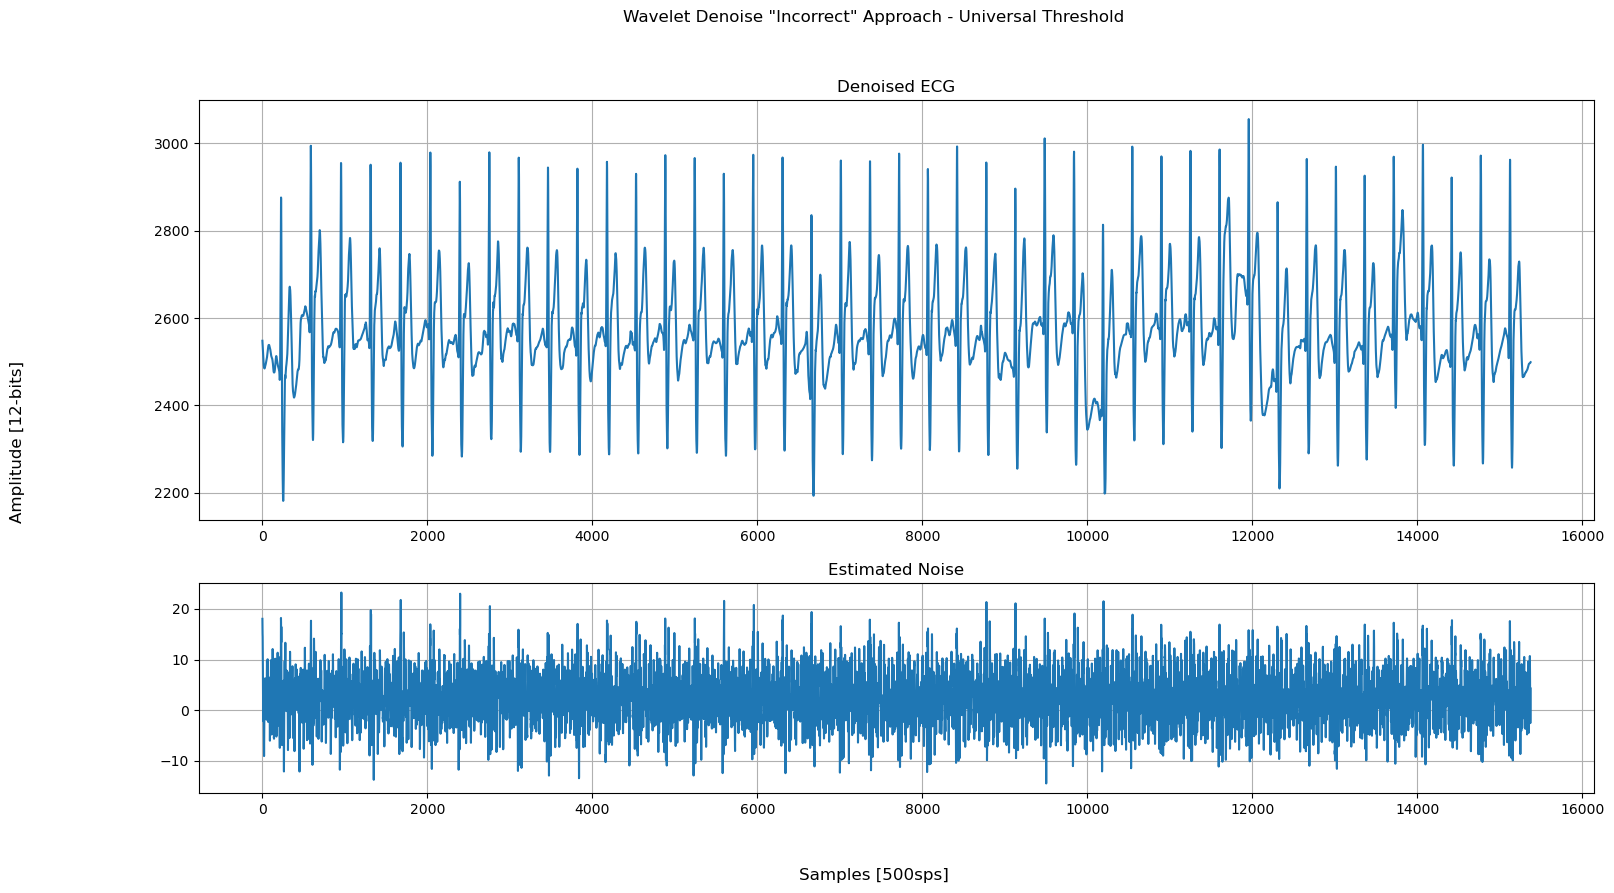

In [9]:
# Signal Denoise
ECG_wv_universal3 = universalWVDenoise3(ECG, 'db4', 5)
e_universal_3 = residuals (ECG_wv_universal3, ECG)
# noise level metrics
mse_universal3 =  meanSquareError(ECG_wv_universal3, ECG)
snr_power_universal_3 = snrPower(ECG_wv_universal3, e_universal_3)
snr_amplitude_universal_3 = snrAmplitude(ECG_wv_universal3, e_universal_3)
snr_MSE_universal_3 = snrMSE(ECG_wv_universal3, ECG)
snr_RMS_universal_3 = snrRMS(ECG_wv_universal3, e_universal_3)
snr_VPP_universal_3 = snrVPP(ECG_wv_universal3, e_universal_3)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise "Incorrect" Approach - Universal Threshold')
axs[0].plot(ECG_wv_universal3)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_3)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

# MiniMax Denoising

Text(0.02, 0.5, 'Amplitude [12-bits]')

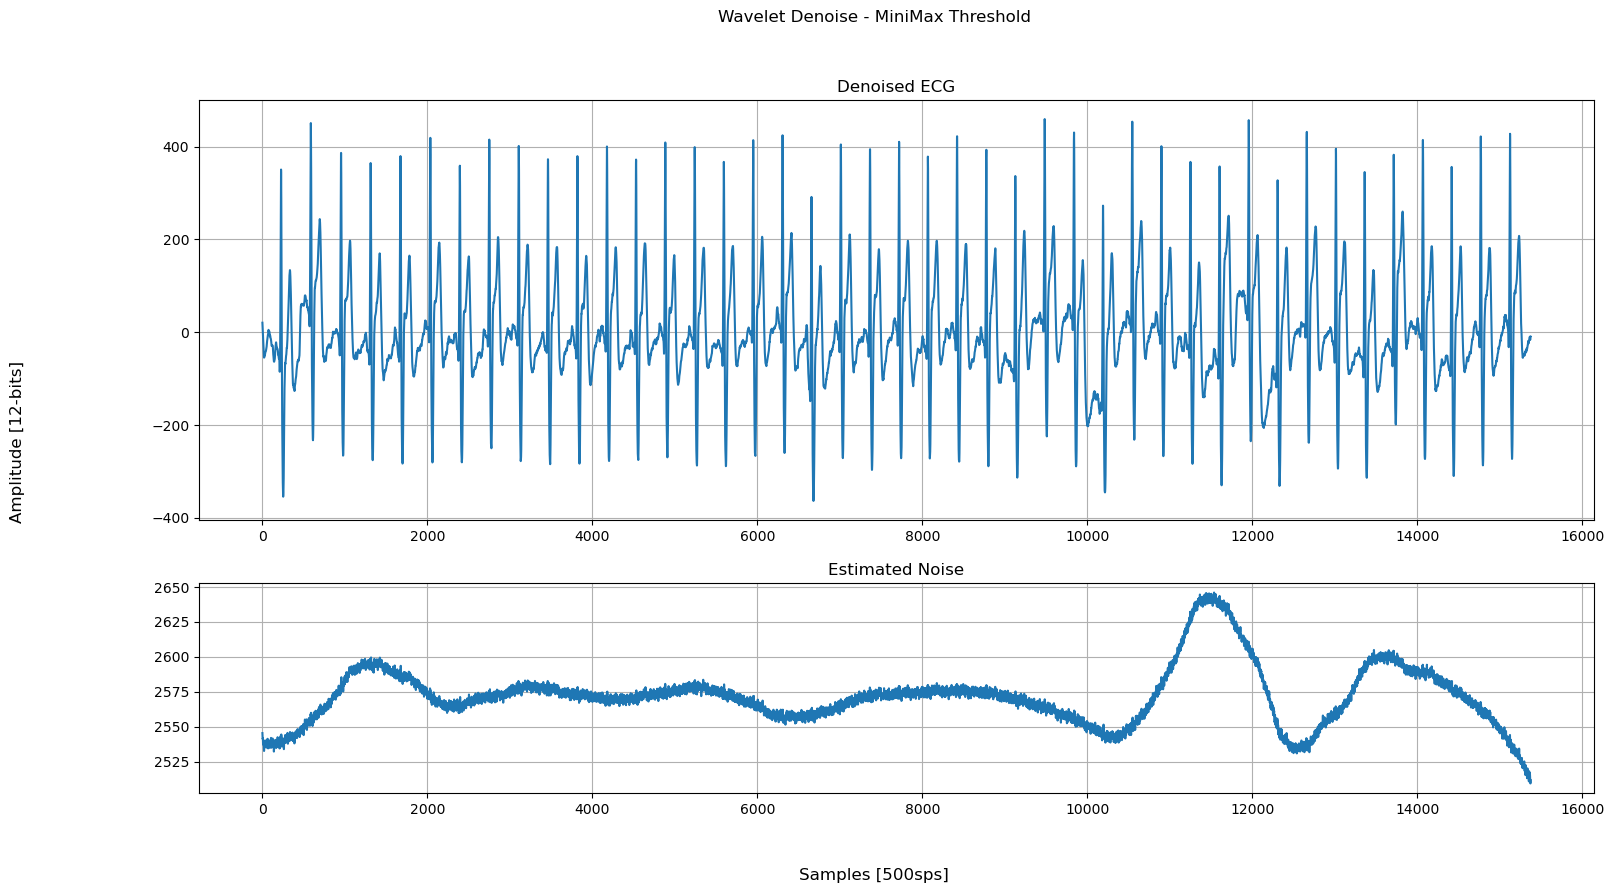

In [10]:
# Signal Denoise
ECG_wv_minimax = minimaxWVDenoise(ECG, 'db4', 10)
e_minimax = residuals (ECG_wv_minimax, ECG)
# noise level metrics
mse_minimax =  meanSquareError(ECG_wv_minimax, ECG)
snr_power_minimax = snrPower(ECG_wv_minimax, e_minimax)
snr_amplitude_minimax = snrAmplitude(ECG_wv_minimax, e_minimax)
snr_MSE_minimax = snrMSE(ECG_wv_minimax, ECG)
snr_RMS_minimax = snrRMS(ECG_wv_minimax, e_minimax)
snr_VPP_minimax = snrVPP(ECG_wv_minimax, e_minimax)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - MiniMax Threshold')
axs[0].plot(ECG_wv_minimax)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_minimax)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

# SURE Denoising

Text(0.02, 0.5, 'Amplitude [12-bits]')

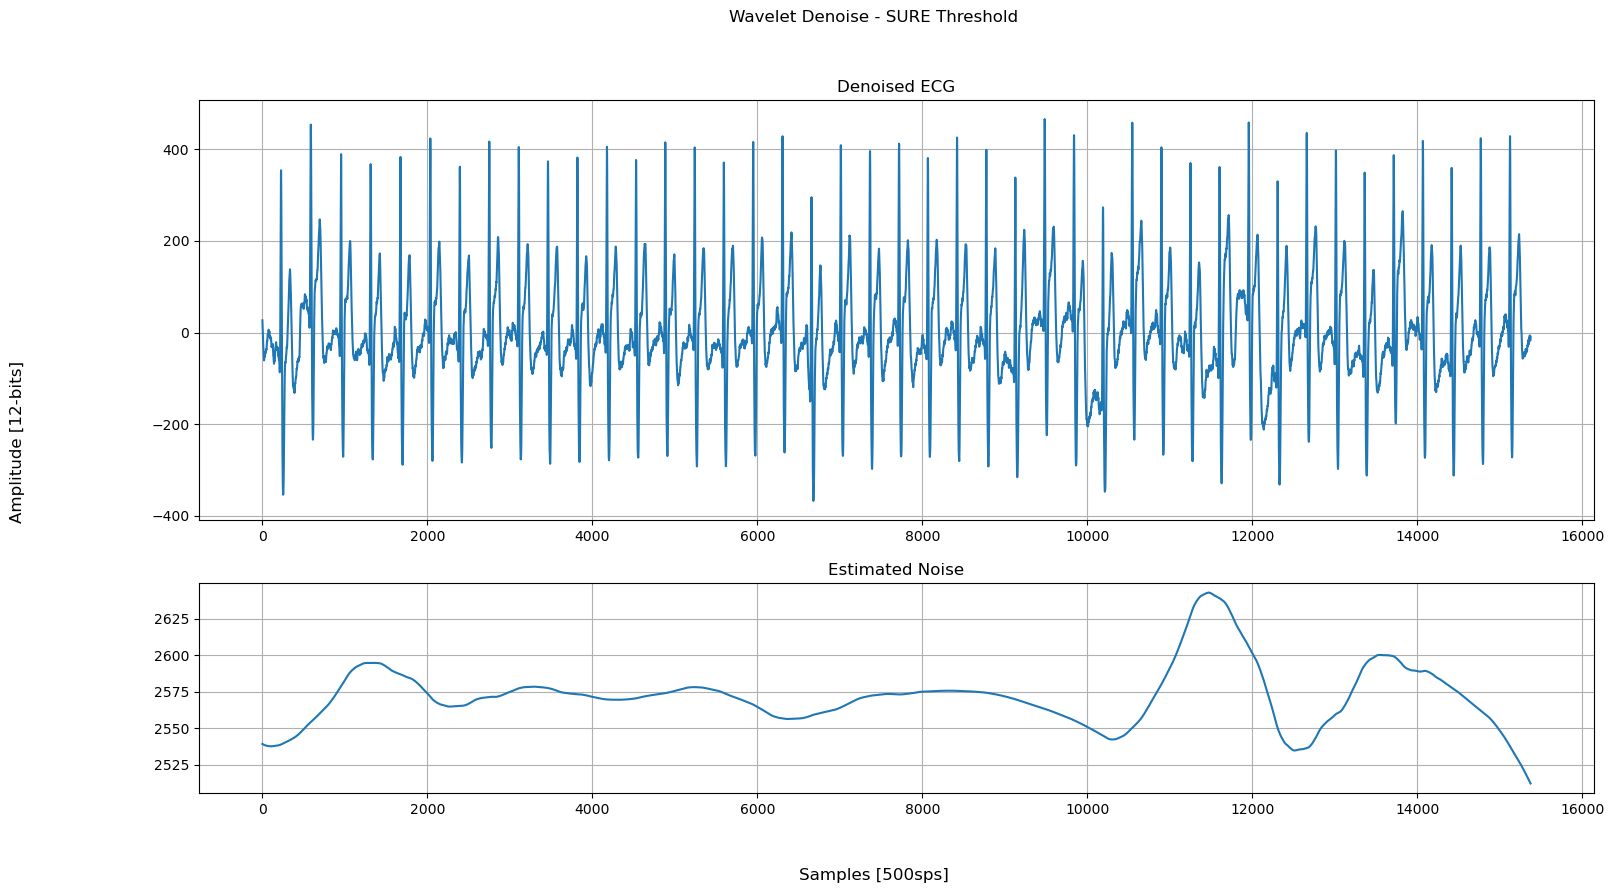

In [11]:
# Signal Denoise
ECG_wv_sure = sureWVDenoise(ECG, 'db4', 10)
e_sure = residuals (ECG_wv_sure, ECG)
# noise level metrics
mse_sure =  meanSquareError(ECG_wv_sure, ECG)
snr_power_sure = snrPower(ECG_wv_sure, e_sure)
snr_amplitude_sure = snrAmplitude(ECG_wv_sure, e_sure)
snr_MSE_sure = snrMSE(ECG_wv_sure, ECG)
snr_RMS_sure = snrRMS(ECG_wv_sure, e_sure)
snr_VPP_sure = snrVPP(ECG_wv_sure, e_sure)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - SURE Threshold')
axs[0].plot(ECG_wv_sure)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_sure)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

# Control Filteling

## Linear phase FIR

Text(0.02, 0.5, 'Amplitude [12-bits]')

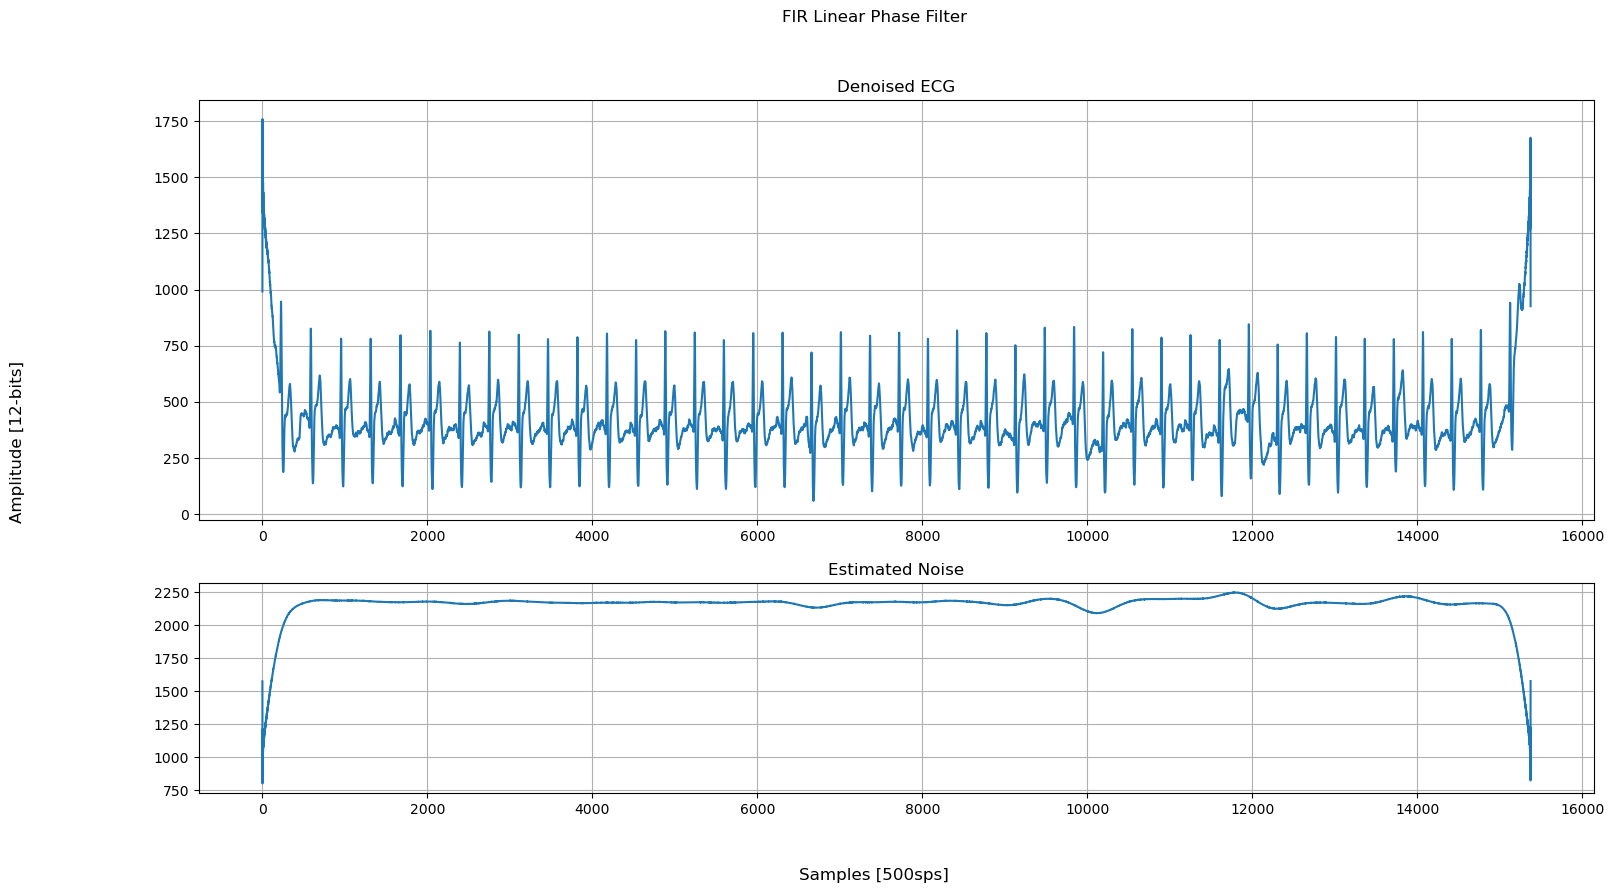

In [12]:
## Linear phase FIR
# Calculate FIR coefficients with window method
# Define the filter specifications
numtaps = 1001                  # Number of taps in the filter
cutoff = [0.002, 0.6]          # Passband frequencies (normalized, from 0 to 1, where 1 is the Nyquist frequency)
window = 'hamming'             # Window type

taps = signal.firwin(numtaps, cutoff, pass_zero=False, window=window)
# Filter Signal
ECG_FIR = np.convolve(ECG, taps, mode='same')
e_FIR = residuals (ECG_FIR, ECG)
# noise level metrics
mse_FIR =  meanSquareError(ECG_FIR, ECG)
snr_power_FIR = snrPower(ECG_FIR, e_FIR)
snr_amplitude_FIR = snrAmplitude(ECG_FIR, e_FIR)
snr_MSE_FIR = snrMSE(ECG_FIR, ECG)
snr_RMS_FIR = snrRMS(ECG_FIR, e_FIR)
snr_VPP_FIR = snrVPP(ECG_FIR, e_FIR)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('FIR Linear Phase Filter')
axs[0].plot(ECG_FIR)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_FIR)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

## IIR Implementation (Not Possible in online computing)

Text(0.02, 0.5, 'Amplitude [12-bits]')

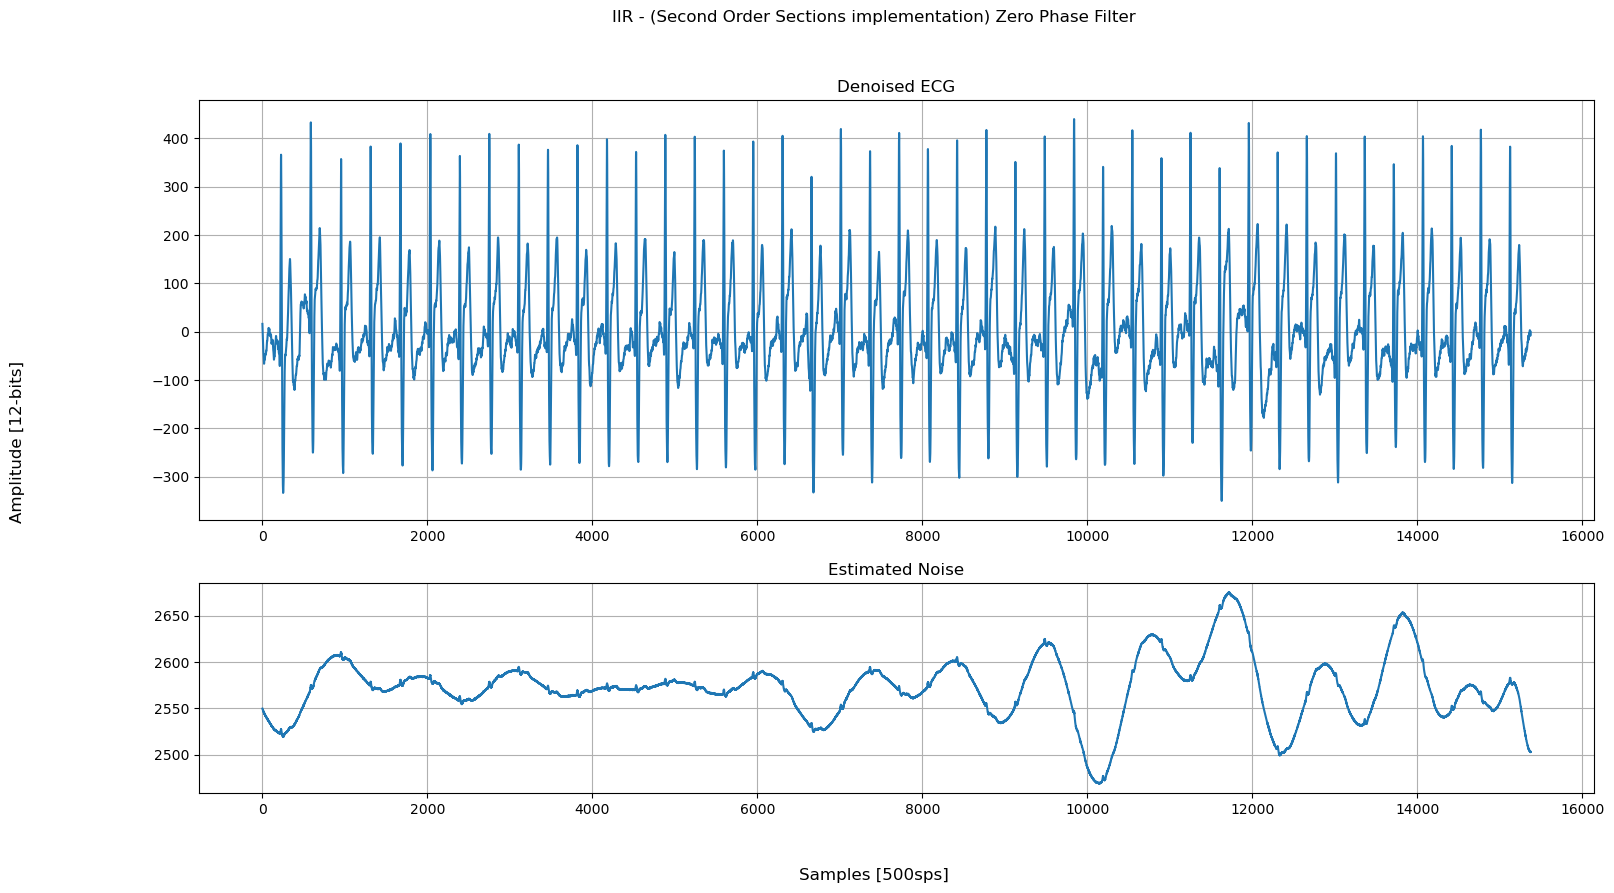

In [13]:
# Signal Denoise
ECG_IIR = bandPassButterworth(ECG, 0.5, 150, 16, ECG_rate)
e_IIR = residuals (ECG_IIR, ECG)
# noise level metrics
mse_IIR =  meanSquareError(ECG_IIR, ECG)
snr_power_IIR = snrPower(ECG_IIR, e_IIR)
snr_amplitude_IIR = snrAmplitude(ECG_IIR, e_IIR)
snr_MSE_IIR = snrMSE(ECG_IIR, ECG)
snr_RMS_IIR = snrRMS(ECG_IIR, e_IIR)
snr_VPP_IIR = snrVPP(ECG_IIR, e_IIR)
# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('IIR - (Second Order Sections implementation) Zero Phase Filter')
axs[0].plot(ECG_IIR)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_IIR)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

# Results Comparison

In [14]:
from IPython.display import Markdown, display

# Create the markdown table
table_md = f"""
| Method                                | MSE              | snrMSE                | snrRMS                | snrVPP                | snrPower                | snrAmplitude                |
| ------                                | ---              | ------                | ------                | ------                | ----                    | -----                       |
| Classic - Universal                   | {mse_universal1} | {snr_MSE_universal_1} | {snr_RMS_universal_1} | {snr_VPP_universal_1} | {snr_power_universal_1} | {snr_amplitude_universal_1} |
| Approximation Elimination - Universal | {mse_universal2} | {snr_MSE_universal_2} | {snr_RMS_universal_2} | {snr_VPP_universal_2} | {snr_power_universal_2} | {snr_amplitude_universal_2} |
| Approximation Thresholded - Universal | {mse_universal3} | {snr_MSE_universal_3} | {snr_RMS_universal_3} | {snr_VPP_universal_3} | {snr_power_universal_3} | {snr_amplitude_universal_3} |
| MiniMax                               | {mse_minimax}    | {snr_MSE_minimax}     | {snr_RMS_minimax}     | {snr_VPP_minimax}     | {snr_power_minimax}     | {snr_amplitude_minimax}     |
| SURE                                  | {mse_sure}       | {snr_MSE_sure}        | {snr_RMS_sure}        | {snr_VPP_sure}        | {snr_power_sure}        | {snr_amplitude_sure}        |
| FIR                                   | {mse_FIR}        | {snr_MSE_FIR}         | {snr_RMS_FIR}         | {snr_VPP_FIR}         | {snr_power_FIR}         | {snr_amplitude_FIR}         | 
| IIR                                   | {mse_IIR}        | {snr_MSE_IIR}         | {snr_RMS_IIR}         | {snr_VPP_IIR}         | {snr_power_IIR}         | {snr_amplitude_IIR}         |
"""

display(Markdown(table_md))


| Method                                | MSE              | snrMSE                | snrRMS                | snrVPP                | snrPower                | snrAmplitude                |
| ------                                | ---              | ------                | ------                | ------                | ----                    | -----                       |
| Classic - Universal                   | 24.82845127432601 | 27.454017599335863 | 13.72684232986501 | 22.43746499347228 | 108.53012042257319 | 13.655153289018944 |
| Approximation Elimination - Universal | 6615559.441020923 | -27.04743646048513 | 7.2740547756135365 | 15.78248230759549 | -54.224555521977074 | 7.439826247293757 |
| Approximation Thresholded - Universal | 30.97033517939013 | 26.494054847467265 | 13.726842329865015 | 22.437464993472283 | 106.5934980544562 | 13.655153289018898 |
| MiniMax                               | 6615519.006120032    | -26.89127054968416     | 7.477057447823495     | 15.97282431723084     | -53.91186170455833     | 7.792481310810003     |
| SURE                                  | 6615508.04405066       | -26.834292998032613        | 7.526376485398114        | 16.04677548566781        | -53.79576721579461        | 8.051789315029765        |
| FIR                                   | 4651789.4237448005        | -22.800789169387382         | 1.3084806121376304         | 11.673695061482796         | -27.405223470820506         | 0.7021513627657562         | 
| IIR                                   | 6618875.319547395        | -27.141148682532194         | 5.319490425743059         | 13.761911489783243         | -54.49153626392055         | 5.828309393511071         |


## Questions

1. How can I modify the SNR definition so it can actually reflect the improvement due to the removal of baselile wandering and DC component? I thought that detrending with the mean would have been enough.
2. Between the three wavelet denoising techniques I think the most efficient so far is the one that assigns the approximation coefficients to 0, but I also want to try removing the mean and median from them and see if there is a baseline removal. Are these approaches minimally mathematically coherent? I haven't found an implementation like this, and I am affraidd I'll be doing something stupid.
3. So far the MSE is resulting a better metric than my tyouts of SNR, wouldd it be formally suitable to quantify the denoising capabilities of the filters?
4. Any way I try to obtanin SNR I keep getting this horrible result where the most negative SNR characterizes the best signal... Fourier would be so disappointed on me :(